In [ ]:
import zipfile

path_to_zip_file = '/content/datadenek2.zip'

directory_to_extract_to = '/content'

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Number of images found: 2938


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Loss: 0.6561
Validation Loss: 0.5652
Precision: 0.9835, Recall: 0.2787, F1 Score: 0.4343
Confusion Matrix:
[[453   2]
 [308 119]]
Epoch 2/50, Loss: 0.3784
Validation Loss: 0.1847
Precision: 0.9297, Recall: 0.9297, F1 Score: 0.9297
Confusion Matrix:
[[425  30]
 [ 30 397]]
Epoch 3/50, Loss: 0.2364
Validation Loss: 0.1166
Precision: 0.9471, Recall: 0.9649, F1 Score: 0.9559
Confusion Matrix:
[[432  23]
 [ 15 412]]
Epoch 4/50, Loss: 0.1892
Validation Loss: 0.1281
Precision: 0.9872, Recall: 0.9063, F1 Score: 0.9451
Confusion Matrix:
[[450   5]
 [ 40 387]]
Epoch 5/50, Loss: 0.1782
Validation Loss: 0.1134
Precision: 0.9810, Recall: 0.9649, F1 Score: 0.9728
Confusion Matrix:
[[447   8]
 [ 15 412]]
Epoch 6/50, Loss: 0.1818
Validation Loss: 0.1070
Precision: 0.9899, Recall: 0.9204, F1 Score: 0.9539
Confusion Matrix:
[[451   4]
 [ 34 393]]
Epoch 7/50, Loss: 0.1812
Validation Loss: 0.1018
Precision: 0.9807, Recall: 0.9508, F1 Score: 0.9655
Confusion Matrix:
[[447   8]
 [ 21 406]]
Epoch 

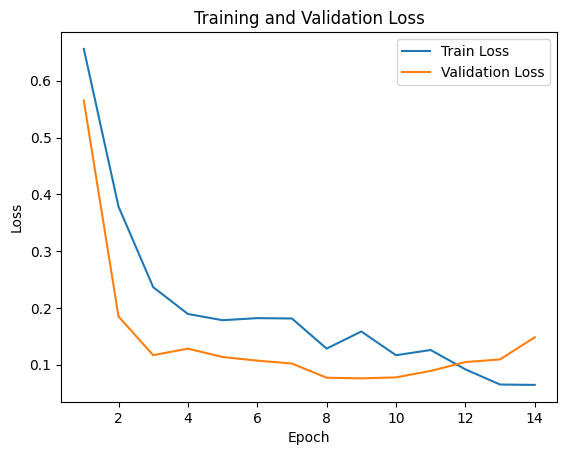

Accuracy: 97.62%
Confusion Matrix:


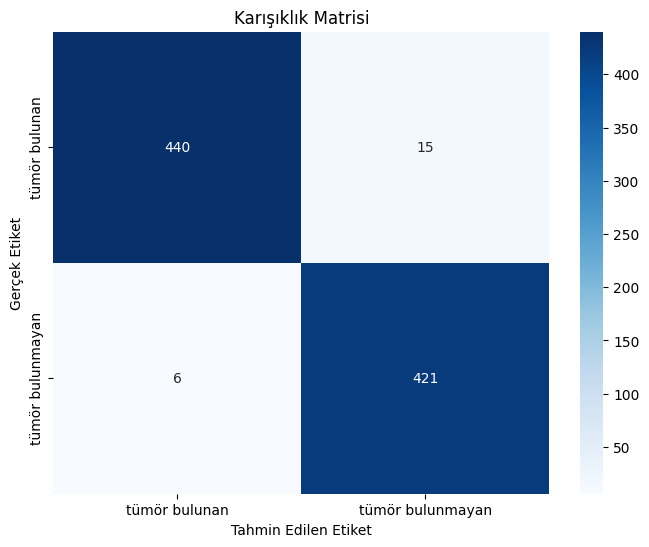

In [ ]:
import importlib
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

image_dir = '/content/datadenek2/beyin/veri'

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
image_paths = []
labels = []

for label, subdir in enumerate(['no1', 'yes1']):
    subdir_path = os.path.join(image_dir, subdir)
    for fname in os.listdir(subdir_path):
        if fname.lower().endswith(valid_extensions):
            image_paths.append(os.path.join(subdir_path, fname))
            labels.append(label)

print(f"Number of images found: {len(image_paths)}")

if len(image_paths) == 0:
    raise ValueError("No valid image files found in the specified directory.")

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42)

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.128, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.128, 0.225]),
])

train_dataset = BrainTumorDataset(train_paths, train_labels, transform=train_transform)
test_dataset = BrainTumorDataset(test_paths, test_labels, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

num_epochs = 50
freeze_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

patience = 5
best_loss = np.inf
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    model.eval()
    val_running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f'Validation Loss: {val_loss:.4f}')

    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    cm = confusion_matrix(all_labels, all_predictions)
    print('Confusion Matrix:')
    print(cm)

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    if epoch + 1 == freeze_epochs:
        for name, param in model.named_parameters():
            if 'classifier' in name:
                param.requires_grad = True
                optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

cm = confusion_matrix(all_labels, all_predictions)
print('Confusion Matrix:')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['tümör bulunan', 'tümör bulunmayan'], yticklabels=['tümör bulunan', 'tümör bulunmayan'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Karışıklık Matrisi')
plt.show()

In [ ]:
def precision_recall_f1_accuracy(confusion_matrix):
    """
    Calculate precision, recall, F1 score, and accuracy from a confusion matrix.

    Parameters:
    confusion_matrix (2x2 array-like): Confusion matrix in the form of:
                                       [[TN, FP],
                                        [FN, TP]]

    Returns:
    dict: A dictionary containing precision, recall, F1 score, and accuracy.
    """
    tn, fp, fn, tp = confusion_matrix.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

# Example usage:
import numpy as np

# Example confusion matrix: [[TN, FP], [FN, TP]]
confusion_matrix = np.array([[440, 15],
                             [6, 421]])

metrics = precision_recall_f1_accuracy(confusion_matrix)
print(metrics)

{'precision': 0.9655963302752294, 'recall': 0.9859484777517564, 'f1': 0.9756662804171495, 'accuracy': 0.9761904761904762}
